# Performance

### Preamble

In [122]:
SYS_PATH = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
SAVE_PATH = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original"
LOAD_PATH = r"C:/Users/mark/Documents/GitHub/honours/dev/package/analysis/output/temp/output.db"

In [123]:
#standard imports
import sys
import numpy as np
import scipy.stats as stats
import pandas as pd
from datetime import date, timedelta
import math
from itertools import chain

#third party imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as tkr
import seaborn as sns
from sklearn import metrics

In [124]:
import importlib
import sys; sys.path.append(SYS_PATH)
import analysis.helper as helper
importlib.reload(helper)
%matplotlib inline

In [125]:
TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE  = 12, 16, 18, 30
plt.style.use(['seaborn-white', 'seaborn-paper'])
sns.set_palette("colorblind")
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
rcParams['figure.figsize'] = (8,3)
pd.set_option('precision',3)
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

### Performance variation by slice date

In [29]:
reload = True

In [30]:
chart_id = "figures/evaluation/performance_slice"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [31]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(20, "evaluate")
    data = data[["F1","MCC","PRC","ROC", "feature_date_str", "forecast_window_years"]]
    total = pd.DataFrame()
    for metric in mtrics:
        temp = data[[metric,"feature_date_str", "forecast_window_years"]]
        temp = temp.rename(index=str, columns={metric: "Score"})
        temp["Metric"] = metric
        total = pd.concat([temp, total], ignore_index=True)
    data = total
    data.to_pickle(pickle_path)

In [32]:
x = "forecast_window_years"
y = "Score"
hue = "Metric"
hue_order = data.groupby(hue)[y].value_counts().index.sort_values(ascending=True).tolist()

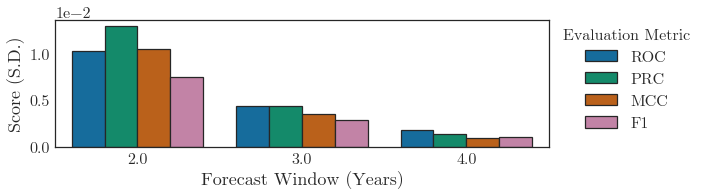

In [33]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, estimator = lambda x: np.std(x), hue=hue, ci =None, **outline_bars)
ax.set_ylabel("Score (S.D.)")
ax.ticklabel_format(style="sci",scilimits=(-2,5),axis='y')
ax.set_xlabel("Forecast Window (Years)")
plt.legend(bbox_to_anchor=(1,1.05), title="Evaluation Metric")
plt.tight_layout()

In [34]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Performance by forecast window

In [63]:
reload = False

In [64]:
chart_id = "figures/evaluation/performance_window"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [65]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = helper.get_results(27, "evaluate")
    data = data[["F1","MCC","PRC","ROC", "feature_date_str", "forecast_window_years"]]
    total = pd.DataFrame()
    mtrics = ["F1","MCC","PRC","ROC"]
    for metric in mtrics:
        temp = data[[metric,"feature_date_str", "forecast_window_years"]]
        temp = temp.rename(index=str, columns={metric: "Score"})
        temp["Metric"] = metric
        total = pd.concat([temp, total], ignore_index=True)
    data = total
    data.to_pickle(pickle_path)

Error: Time
Error: Imputer
Error: Transformer
Error: Scaler
Error: Extractor


In [66]:
x = "Metric" 
y = "Score"
hue = "forecast_window_years"
hue_order = data.groupby(hue)[y].value_counts().index.sort_values(ascending=True).tolist()

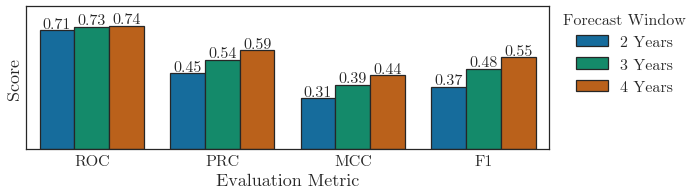

In [67]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, estimator = np.mean, hue=hue, ci=None, **outline_bars)
auto_label(ax, fmt='{:,.2f}')
ax.set_ylabel("Score")
ax.set_xlabel("Evaluation Metric")
plt.legend(bbox_to_anchor=(1,1.05), title="Forecast Window")
plt.tight_layout()

In [68]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Performance by target outcome

In [131]:
reload = True

In [132]:
chart_id = "figures/evaluation/performance_outcome"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [133]:
def get_data():
    data = helper.get_results(28, "evaluate")
    data["label_type"] = data["label_type"].apply(lambda x: x.replace("_"," "))
    data = data[["Y_Pred", "Y_True", "label_type","forecast_window_years","feature_date_str"]]
    data = helper.get_feature_values(data)
    results = helper.feature_function(data, metrics.f1_score, group = ["forecast_window_years","label_type"])
    if type(results) is pd.Series: results = results.to_frame()
    results = results.reset_index(drop=False)
    results = results.rename(index=str, columns={0:"score","index":"label_type"})
    data = results
    return data

In [134]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [135]:
x = "label_type"
y = "score"
hue= "forecast_window_years"
order = ["Extra Stage", "Extra Round", "Exit", "Acquisition", "IPO"]

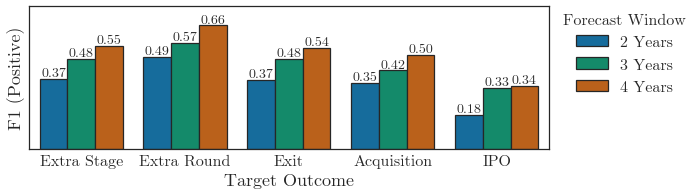

In [139]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, hue=hue, order=order, **outline_bars)
helper.auto_label(ax, fmt='{:,.2f}',size=SMALL_SIZE-2)
ax.set_xlabel("Target Outcome")
ax.set_ylabel("F1 (Positive)")
plt.legend(bbox_to_anchor=(1,1.05), title="Forecast Window")
plt.tight_layout()

In [140]:
output_path = "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Performance by developmental stage

In [141]:
reload = True

In [142]:
chart_id = "figures/evaluation/performance_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [143]:
def get_set(n, name, individual=True):
    data = helper.get_results(*n)
    if individual: stage = "feature_stage_single"
    else: stage = "feature_stage"
    data = data[["Y_Pred", "Y_True","forecast_window_years","feature_date_str", stage]]
    data = get_feature_values(data)
    results = feature_function(data, metrics.f1_score, group = [stage])
    overall = feature_function(data, metrics.f1_score)
    results["Overall"] = overall
    if type(results) is pd.Series: results = results.to_frame()
    results["method"] = name
    return results

In [144]:
def get_data():
    results1 = get_set((27, "evaluate"), "Combined", individual=False)
    results2 = get_set((29, "evaluate"), "Individual", individual=True)
    results3 = get_set((21, "evaluate"), "Individual\n(ex.Patents)", individual=True)
    results = pd.concat([results1, results2, results3], axis=0)
    results = results.reset_index(drop=False)
    results = results.rename(index=str, columns={0:"score","index":"stage"})
    data = results
    return data

In [145]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [146]:
x = "stage"
y = "score"
hue = "method"
hue_order = ['Combined', "Individual\n(ex.Patents)", "Individual"]

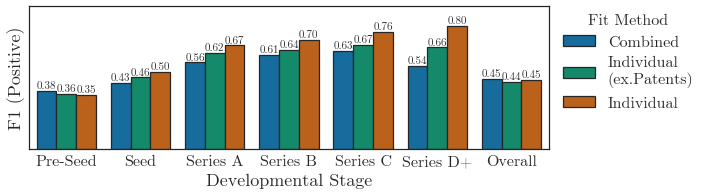

In [148]:
f = plt.figure()
ax = sns.barplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, **outline_bars)
helper.auto_label(ax, fmt='{:,.2f}',size=TINY_SIZE-1)
ax.set_xlabel("Developmental Stage")
ax.set_ylabel("F1 (Positive)")
plt.legend(bbox_to_anchor=(1,1.05), title="Fit Method")
plt.tight_layout()

In [149]:
output_path = "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Example company profiles and their predictions